In [1]:
import os
import time
import glob
import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.special import expit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from baseline import *

In [2]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Prepare Dataset

In [3]:
lp_train = pickle.load(open('data/cora/lp_train.pkl', 'rb'))
lp_test = pickle.load(open('data/cora/lp_test.pkl', 'rb'))

node_features = pickle.load(open('data/cora/node_features.pkl', 'rb'))
text_features = node_features.toarray()
nnodes = text_features.shape[0]

pca = PCA(n_components=100)
pca.fit(text_features)
emb_features = pca.transform(text_features)
emb_features = torch.from_numpy(emb_features).to(device).float()
    
adjs = defaultdict(set)
for node in list(lp_train.nodes()):
    adjs[node] = adjs[node].union(lp_train[node])
adjs = [np.sort(list(v)) for k,v in adjs.items()]

## Parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nlayer = 1
dims = [100]*(nlayer+1)
dropout = 0.4

lr = 0.005
weight_decay = 0.0005

patience = 50
nepoch = 10000

## Link Prediction Supervised Training

In [5]:
# posi, nega = [], []
# for node in range(nnodes):
#     neighbors = list(lp_train[node])
#     nega_neighbors = random.sample(list(set(range(nnodes)).difference(set(neighbors))), 5)
#     nega.append(np.stack(([node]*len(nega_neighbors), nega_neighbors), axis=-1))
#     posi.append(np.stack(([node]*len(neighbors), neighbors), axis=-1))
# posi = np.concatenate(posi, axis=0)
# nega = np.concatenate(nega, axis=0)

# X_train = np.concatenate([posi,nega], axis=0)
# y_train = torch.from_numpy(np.concatenate([[1]*len(posi), [0]*len(nega)])).float().to(device)
# X_test = lp_test[:,:-1]
# y_test = torch.from_numpy(lp_test[:,-1]).float().to(device)

In [6]:
X_train, y_train, X_test, y_test = pickle.load(open('simulation/train_test.pkl', 'rb'))
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

## Train & Test

In [7]:
def evaluate(cos_sim, labels):
    pred = expit(cos_sim)>0.5
    f1, accuracy = f1_score(labels, pred), accuracy_score(labels, pred)
    return accuracy, f1

In [8]:
pdist = nn.PairwiseDistance()
edges = np.array(list(lp_train.edges()))

def edge_diff(embeds):
    diff = pdist(embeds[edges[:,0]], embeds[edges[:,1]])
    return torch.mean(diff).cpu().item()

def embed_diff(embeds, prev_embeds):
    diff = pdist(embeds, prev_embeds)
    return torch.mean(diff).cpu().item()

In [9]:
cos = nn.CosineSimilarity()

def sup_train(model, optimizer, epoch, prev_embeds):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        if len(neighbors)>2:
            real_neighbors = random.sample(neighbors.tolist(), 2)
        else:
            real_neighbors = list(neighbors)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_train[:,0]], embeds[X_train[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_train)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_train.cpu().numpy())
    curr_edge_diff = edge_diff(embeds)
    curr_embed_diff = embed_diff(embeds, prev_embeds)
    curr_input_diff = embed_diff(embeds, emb_features)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1==0:
        print('Epoch: {} || Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f} || Edge_diff: {:.4f}, Embed_diff: {:.4f}, Input_diff: {:.4f} || Time: {:.4f}s'
              .format(epoch, loss.item(), accuracy, f1, curr_edge_diff, curr_embed_diff, curr_input_diff, time.time()-t))
    
    return loss.item(), curr_edge_diff, curr_embed_diff, curr_input_diff, embeds

In [10]:
def sup_test(model):
    model.eval()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        if len(neighbors)>2:
            real_neighbors = random.sample(neighbors.tolist(), 2)
        else:
            real_neighbors = list(neighbors)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_test[:,0]], embeds[X_test[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_test)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_test.cpu().numpy())
    
    print('Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}'.format(loss.item(), accuracy, f1))

In [11]:
t_total = time.time()

model = GraphSAGEModel(dims=dims, dropout=dropout, nlayer=nlayer, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

prev_embeds = emb_features
loss_values, edge_diffs, embed_diffs, input_diffs = [], [], [], []
bad_counter, best, best_epoch = 0, nepoch+1, 0
for epoch in range(nepoch):
    loss_value, curr_edge_diff, curr_embed_diff, curr_input_diff, prev_embeds = sup_train(model, optimizer, epoch, prev_embeds)
    
    loss_values.append(loss_value)
    edge_diffs.append(curr_edge_diff)
    embed_diffs.append(curr_embed_diff)
    input_diffs.append(curr_input_diff)
    
    torch.save(model.state_dict(), 'model/Supervised/{}.pkl'.format(epoch))
    
    if loss_values[-1] < best:
        best, best_epoch, bad_counter = loss_values[-1], epoch, 0
    else:
        bad_counter += 1
                
    if bad_counter == patience:
        break
        
    files = glob.glob('model/Supervised/*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0].split('/')[-1])
        if epoch_nb < best_epoch:
            os.remove(file) 
    
files = glob.glob('model/Supervised/*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0].split('/')[-1])
    if epoch_nb > best_epoch:
        os.remove(file) 
        
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('model/Supervised/{}.pkl'.format(best_epoch)))

sup_test(model)

Epoch: 0 || Loss: 0.6999, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8040, Embed_diff: 1.0149, Input_diff: 1.0149 || Time: 0.5248s
Epoch: 1 || Loss: 0.6965, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7935, Embed_diff: 0.7873, Input_diff: 1.0148 || Time: 0.3344s
Epoch: 2 || Loss: 0.6938, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7773, Embed_diff: 0.7839, Input_diff: 1.0145 || Time: 0.3258s
Epoch: 3 || Loss: 0.6910, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7758, Embed_diff: 0.7633, Input_diff: 1.0142 || Time: 0.3294s
Epoch: 4 || Loss: 0.6892, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7736, Embed_diff: 0.7563, Input_diff: 1.0144 || Time: 0.3220s
Epoch: 5 || Loss: 0.6862, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7647, Embed_diff: 0.7536, Input_diff: 1.0142 || Time: 0.3643s
Epoch: 6 || Loss: 0.6819, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7406, Embed_diff: 0.7317, Input_diff: 1.0139 || Time: 0.3264s
Epoch: 7 || Loss: 0.6804, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.7385, Embed_diff: 0.7279, Input_diff: 

Epoch: 64 || Loss: 0.6376, Acc: 0.3929, F1: 0.5604 || Edge_diff: 0.6057, Embed_diff: 0.5684, Input_diff: 1.0148 || Time: 0.3204s
Epoch: 65 || Loss: 0.6390, Acc: 0.3924, F1: 0.5602 || Edge_diff: 0.6121, Embed_diff: 0.5741, Input_diff: 1.0149 || Time: 0.3253s
Epoch: 66 || Loss: 0.6375, Acc: 0.3964, F1: 0.5618 || Edge_diff: 0.6084, Embed_diff: 0.5750, Input_diff: 1.0150 || Time: 0.3237s
Epoch: 67 || Loss: 0.6382, Acc: 0.3946, F1: 0.5611 || Edge_diff: 0.6136, Embed_diff: 0.5736, Input_diff: 1.0149 || Time: 0.3320s
Epoch: 68 || Loss: 0.6378, Acc: 0.3939, F1: 0.5608 || Edge_diff: 0.6152, Embed_diff: 0.5704, Input_diff: 1.0148 || Time: 0.3288s
Epoch: 69 || Loss: 0.6371, Acc: 0.3940, F1: 0.5608 || Edge_diff: 0.6084, Embed_diff: 0.5705, Input_diff: 1.0150 || Time: 0.3256s
Epoch: 70 || Loss: 0.6350, Acc: 0.3963, F1: 0.5617 || Edge_diff: 0.6079, Embed_diff: 0.5692, Input_diff: 1.0149 || Time: 0.3362s
Epoch: 71 || Loss: 0.6390, Acc: 0.3950, F1: 0.5612 || Edge_diff: 0.6170, Embed_diff: 0.5772, Inpu

Epoch: 128 || Loss: 0.6371, Acc: 0.3976, F1: 0.5623 || Edge_diff: 0.6079, Embed_diff: 0.5825, Input_diff: 1.0160 || Time: 0.3245s
Epoch: 129 || Loss: 0.6371, Acc: 0.3982, F1: 0.5625 || Edge_diff: 0.6119, Embed_diff: 0.5750, Input_diff: 1.0157 || Time: 0.3296s
Epoch: 130 || Loss: 0.6376, Acc: 0.3962, F1: 0.5615 || Edge_diff: 0.6089, Embed_diff: 0.5726, Input_diff: 1.0155 || Time: 0.3320s
Epoch: 131 || Loss: 0.6382, Acc: 0.3967, F1: 0.5620 || Edge_diff: 0.6237, Embed_diff: 0.5740, Input_diff: 1.0159 || Time: 0.3415s
Epoch: 132 || Loss: 0.6370, Acc: 0.3973, F1: 0.5621 || Edge_diff: 0.6176, Embed_diff: 0.5716, Input_diff: 1.0157 || Time: 0.3218s
Epoch: 133 || Loss: 0.6375, Acc: 0.3966, F1: 0.5617 || Edge_diff: 0.6127, Embed_diff: 0.5778, Input_diff: 1.0159 || Time: 0.3344s
Epoch: 134 || Loss: 0.6366, Acc: 0.3968, F1: 0.5620 || Edge_diff: 0.6171, Embed_diff: 0.5677, Input_diff: 1.0159 || Time: 0.3257s
Epoch: 135 || Loss: 0.6369, Acc: 0.3941, F1: 0.5609 || Edge_diff: 0.6137, Embed_diff: 0.56

Epoch: 192 || Loss: 0.6380, Acc: 0.3974, F1: 0.5621 || Edge_diff: 0.6177, Embed_diff: 0.5828, Input_diff: 1.0160 || Time: 0.3208s
Epoch: 193 || Loss: 0.6351, Acc: 0.4020, F1: 0.5639 || Edge_diff: 0.6108, Embed_diff: 0.5751, Input_diff: 1.0159 || Time: 0.3212s
Epoch: 194 || Loss: 0.6368, Acc: 0.3976, F1: 0.5623 || Edge_diff: 0.6135, Embed_diff: 0.5806, Input_diff: 1.0157 || Time: 0.3236s
Epoch: 195 || Loss: 0.6366, Acc: 0.3990, F1: 0.5629 || Edge_diff: 0.6228, Embed_diff: 0.5764, Input_diff: 1.0159 || Time: 0.3319s
Epoch: 196 || Loss: 0.6374, Acc: 0.3959, F1: 0.5617 || Edge_diff: 0.6087, Embed_diff: 0.5745, Input_diff: 1.0158 || Time: 0.3294s
Epoch: 197 || Loss: 0.6376, Acc: 0.3954, F1: 0.5615 || Edge_diff: 0.6099, Embed_diff: 0.5785, Input_diff: 1.0158 || Time: 0.3224s
Epoch: 198 || Loss: 0.6385, Acc: 0.4009, F1: 0.5636 || Edge_diff: 0.6289, Embed_diff: 0.5824, Input_diff: 1.0159 || Time: 0.3171s
Epoch: 199 || Loss: 0.6378, Acc: 0.3959, F1: 0.5617 || Edge_diff: 0.6136, Embed_diff: 0.58

Text(0.5, 1.0, 'Training Loss Curve')

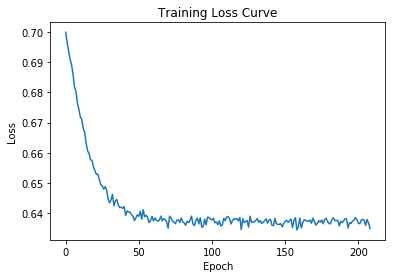

In [12]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

Text(0.5, 1.0, 'Training Edge-wise Distance Curve')

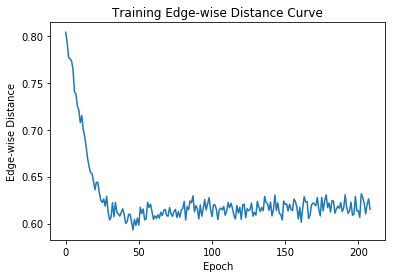

In [13]:
plt.plot(edge_diffs)
plt.xlabel('Epoch')
plt.ylabel('Edge-wise Distance')
plt.title('Training Edge-wise Distance Curve')

Text(0.5, 1.0, 'Change in Embedding Curve')

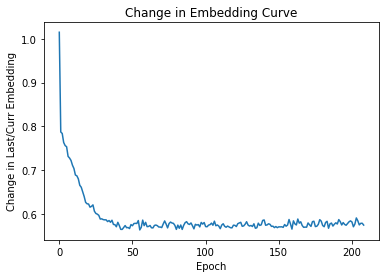

In [14]:
plt.plot(embed_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Last/Curr Embedding')
plt.title('Change in Embedding Curve')

Text(0.5, 1.0, 'Change in Input/Output Curve')

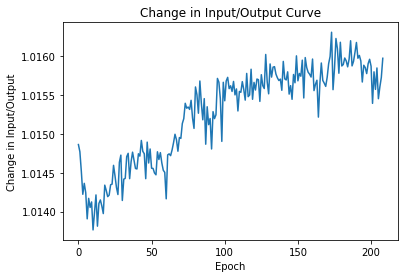

In [15]:
plt.plot(input_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Input/Output')
plt.title('Change in Input/Output Curve')